In [1]:
import numpy as np 
import cv2 
import matplotlib.pyplot as plt
from tools import read_video_frames

In [2]:
img = cv2.imread("/Users/hendricpopma/Documents/Uni/Uni_6_Sem/Bums/project_bums/Test_Bilder/IMG_7546.jpeg", 0 )
plt.gray()

<Figure size 640x480 with 0 Axes>

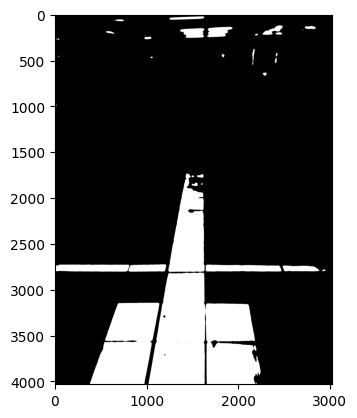

In [3]:
gauss = cv2.GaussianBlur(img, None, 10)
plt.imshow(gauss)
t, seg = cv2.threshold(gauss,200,1,cv2.THRESH_BINARY) #streifen = 200 +cv2.THRESH_OTSU
plt.imshow(seg)

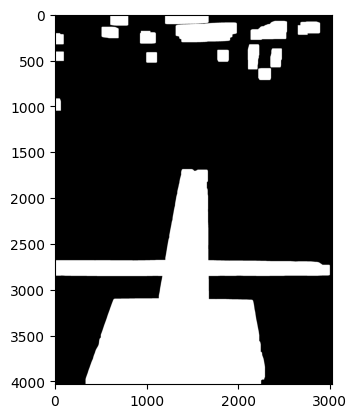

In [10]:
seg = cv2.dilate(seg, np.ones((7,7)), iterations=8) #7
plt.imshow(seg)

In [5]:
#skeletonize 
def skeletonize(binary):
    # Convert the image to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # # Threshold the image to create a binary image
    # _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    # Apply morphological operations to thin the image
    size = np.size(binary)
    skel = np.zeros(binary.shape, np.uint8)
    
    element = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
    done = False
    
    while not done:
        eroded = cv2.erode(binary, element)
        temp = cv2.dilate(eroded, element)
        temp = cv2.subtract(binary, temp)
        skel = cv2.bitwise_or(skel, temp)
        binary = eroded.copy()
        
        zeros = size - cv2.countNonZero(binary)
        if zeros == size:
            done = True
    
    return skel

In [ ]:
skel = skeletonize(seg)
plt.imshow(skel)

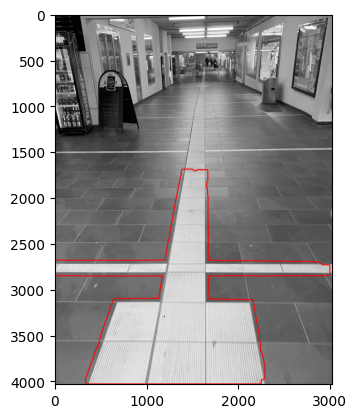

In [20]:
cnts, hierachy = cv2.findContours(seg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
out = cv2.merge((img, img, img))
area = []
for cnt in cnts:
    area.append(cv2.contourArea(cnt))
c_idx = area.index(max(area))

cv2.drawContours(out, cnts, c_idx, [255,0,0], 10)
plt.imshow(out)

In [ ]:
#create box around contour
rect = cv2.minAreaRect(cnts[c_idx])
box = cv2.boxPoints(rect)
box = np.int0(box) 
cv2.drawContours(out,[box],0,(0,0,255),2)
plt.imshow(out)

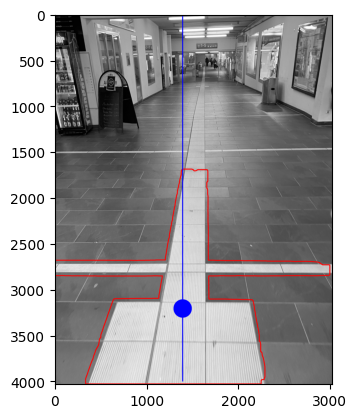

In [19]:
#find center of ther contour
m = cv2.moments(cnts[c_idx])
cX = int(m["m10"] / m["m00"])
cY = int(m["m01"] / m["m00"])
res = cv2.circle(out, (cX, cY),100, [0,0,255], cv2.FILLED)
cv2.line(res, (cX,0),(cX,4000), [0, 0, 255], 10)
plt.imshow(res)

In [31]:
#add to master 
def find_center_plot(img):
    m = cv2.moments(img)
    cX = int(m["m10"] / m["m00"])
    cY = int(m["m01"] / m["m00"])
    center_koords =  [cX,cY]
    img_res = cv2.circle(img, (cX, cY),100, [0,0,255], cv2.FILLED)
    return img_res, center_koords

[array([0.83912885], dtype=float32),
 array([-0.54393274], dtype=float32),
 array([1258.0602], dtype=float32),
 array([2996.1155], dtype=float32)]

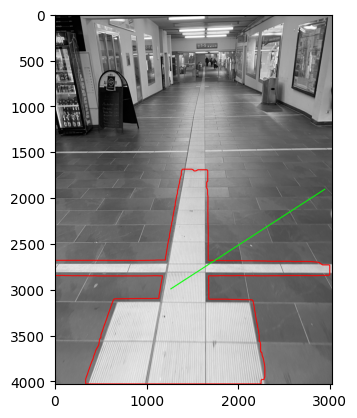

In [37]:
#fit line through contour
rows,cols = img.shape[:2]
[vx,vy,x,y] = cv2.fitLine(cnts[c_idx], cv2.DIST_L2,0,0.01,0.01)
x1 = int(x+2000*vx)
y1 = int(y+2000*vy)
cv2.line(out,(int(x), int(y)),(x1,y1),(0,255,0),10)
plt.imshow(out)
[vx,vy,x,y]

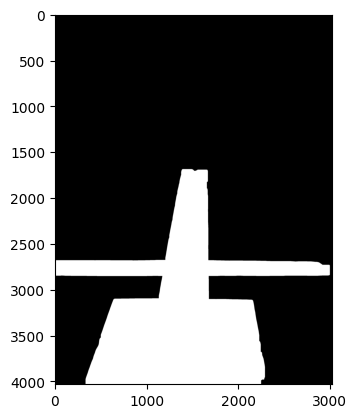

In [12]:

black = np.zeros(np.shape(img),dtype='uint8')
cv2.drawContours(black, cnts, c_idx, [255,255,255], cv2.FILLED)
plt.imshow(black)

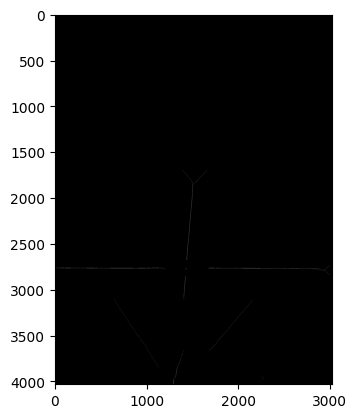

In [14]:
skel = skeletonize(black)
plt.imshow(skel)

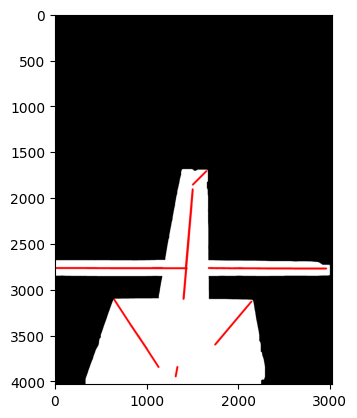

In [15]:
linesh = cv2.HoughLinesP(skel, 1, np.pi/180, 60,
                        minLineLength=100, maxLineGap=300)

lines=np.squeeze(linesh)
black_new = cv2.merge((black, black, black))
for (x1,y1,x2,y2) in lines:
    cv2.line(black_new, (x1,y1), (x2,y2), (255,0,0), 20)
plt.imshow(black_new)

In [21]:
black_up = black[:3000,:]
black_down = black[3000:,:]

In [32]:
c_black_up, koords_up = find_center_plot(black_up)
c_black_down, koords_down = find_center_plot(black_down)

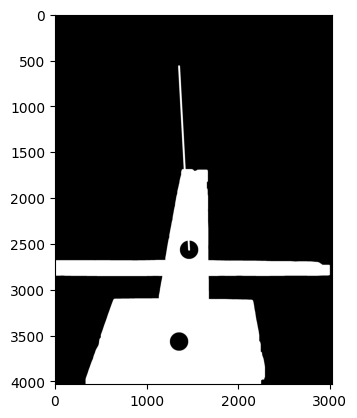

In [36]:
c_new = np.concatenate((c_black_up, c_black_down))
cv2.line(c_new, koords_up, koords_down, [255, 255,255], 20)
plt.imshow(c_new)

In [38]:
koords_down[0]

1349

In [ ]:
derx=cv2.Sobel(black_short, cv2.CV_32F, 1, 0,)
dery=cv2.Sobel(black_short, cv2.CV_32F, 0, 1,)
gradmag=np.sqrt(derx**2 + dery**2)
plt.imshow(gradmag > 250)
gradmag_w = (gradmag > 250).astype('uint8')
canny = cv2.Canny(black_short, 0, 0)
plt.imshow(canny)

In [ ]:
# canny = cv2.Canny(black_short,0 ,0,)
# plt.imshow(canny)
linesh = cv2.HoughLinesP(canny, 1, np.pi/180, 60,
                        minLineLength=100, maxLineGap=300)

lines=np.squeeze(linesh)
black_new = cv2.merge((black_short, black_short, black_short))
for (x1,y1,x2,y2) in lines:
    cv2.line(black_new, (x1,y1), (x2,y2), (255,0,0), 20)
plt.imshow(black_new)

In [ ]:
# put mask on picture = mask has to be same shape 
new_img = cv2.bitwise_and(img, img, mask=black)
plt.imshow(new_img)

In [ ]:
# find the longes line in x and y 
height, width, _ = black_new.shape
diffx = []
diffy = []
for (x1,y1,x2,y2) in lines:
    diffx.append(x2-x1)
    diffy.append(y2-y1)
diffx.index(max(diffx))
llinex = lines[diffx.index(max(diffx))]
lliney = lines[diffy.index(max(diffy))]
blank = np.zeros(black_new.shape, dtype=np.uint8)
blank = cv2.line(blank, (llinex[0],llinex[1]), (llinex[2],llinex[3]), (255,255,255), 10)
#blank = cv2.line(blank, (lliney[0],lliney[1]), (lliney[2],lliney[3]), (255,255,255), 10 ) 
blank = cv2.line(blank, (lliney[0],0), (lliney[2],height), (255,255,255), 10 ) 
blank = cv2.line(blank, (lliney[0]-50,lliney[1]), (lliney[2]-50,lliney[3]), (255,255,255), 10 )
blank = cv2.line(blank, (lliney[0]+50,lliney[1]), (lliney[2]+50,lliney[3]), (255,255,255), 10 )
plt.imshow(blank)

vertical line  -> longest line and connect it over the hole picture
horizontal line -> extend it to the vertical line or check if longest horizontal line is left or right fromm the vertical line


In [ ]:
#find intersections from script with offset line 
# so we get two/three intersections left and rigth from the "masterline"
def find_intersection(l1, l2, offset):
    x1=l1[0]; y1=l1[1]
    x2=l1[2]; y2=l1[3]
    x3=l2[0]+offset; y3=l2[1]
    x4=l2[2]+offset; y4=l2[3]
    denom=(x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
    #print(denom)
    if(denom):
        px=((x1*y2-y1*x2)*(x3-x4) - (x1-x2)*(x3*y4-y3*x4))/denom 
        py=((x1*y2-y1*x2)*(y3-y4) - (y1-y2)*(x3*y4-y3*x4))/denom
    else: 
        px=-1
        py=-1
    return (px,py)
sy,sx=img.shape
px=[]
py=[]
for x in range(-50,50,50):
    p=find_intersection(llinex,lliney,x)
    if(p[0]>0 and p[0]<sx and p[1]>0 and p[1]<sy):
        px.append(p[0])
        py.append(p[1])

#res = final.copy()
for x in range(len(px)):
    blank = cv2.circle(blank, (px[x].astype('int'), py[x].astype('int')),10, [255,255,255])
plt.imshow(blank)

In [ ]:
#line to right or left
if px[0] - px[1] < 0: 
    print("go left")
elif px[0] - px[1] > 0: 
    print("go right")
if len(px) > 2:
    print("you can go left or right") 